# Distributed Applications
## Project 1: Cloud-based Deployment and Testing

In [114]:
# clear all values
%reset -f

In [115]:
import os
import numpy as np
import requests
import time
import concurrent.futures
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pickle

# Code for the Analysis

## Definition of the functions

### Test functions

The function `concurrent_test` is used to test the performance of the API requests. This function sends multiple requests to a server concurrently using Python's ThreadPoolExecutor, and calculates the total response time for each request. The function takes in the DNS, port, list of requests, number of requests, and request type (either REST or SOAP) as inputs. The output is a dictionary containing the total response time for each request.

In [116]:
def parse_soap_elements(xml_str):
    root = ET.fromstring(xml_str)
    element_dict = {element.tag.split('}')[1]: element.text for element in root.iter() if '}' in element.tag}
    identifier = list(element_dict.keys())[-1]
    return identifier, element_dict[identifier]

def send_rest(url, method, payload=None):
    try:
        if method == "GET":
            response = requests.get(url)
        elif method == "POST":
            response = requests.post(url, json=payload)
        elif method == "PUT":
            response = requests.put(url, json=payload)
        elif method == "DELETE":
            response = requests.delete(url)
        else:
            raise ValueError(f"Invalid method {method}")
    except:
        print(f"Request failed: {url}")
        return None
    return response

def send_soap(url, data):
    headers = {
        'Content-Type': 'text/xml',
        'SOAPAction': '',
    }
    response = requests.post(url, data=data, headers=headers)
    return response

def concurrent_test(dns, port, request_list, num_requests, req='REST'):
    # print server name
    server = f"http://{dns}:{port}"
    country = server.split('.')[1]
    print(f"Server: {country}")
    
    # test every request
    response_times_dict = {}
    for request in request_list: 
        # parse request
        url, method, *args = request
        if req == 'SOAP':
            identifier = parse_soap_elements(method)[0]
        elif req == 'REST':
            identifier = url
        payload = args[0] if args else None
        
        # send requests concurrently
        response_times = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for i in range(num_requests):
                # start timer
                start_time = time.perf_counter()
                # send request
                if req == 'REST': send_rest(server + url, method, payload)
                elif req == 'SOAP': send_soap(server + url, payload)
                # end timer
                end_time = time.perf_counter()
                # calculate response time
                response_time = end_time - start_time
                # add response time to list
                response_times.append(response_time)
            # total time rounded to 3 decimal places
            total_time = round(sum(response_times), 3)
            
            if identifier in response_times_dict:
                response_times_dict[identifier] += total_time
            else:
                response_times_dict[identifier] = total_time
            if req == 'REST': 
                print(f"URL: {url}, Method: {method}, Total Response Time: {total_time}")
            elif req == 'SOAP':
                print(f"URL: {identifier}, Method: {parse_soap_elements(method)}, Total Response Time: {total_time}")
    return response_times_dict

### Other Functions

In [117]:
def plot_data(data, num_requests, title='Response Time by API ', ylabel='Response Time (s)', extra_title=None):
    # add the number of trials to the extra title   
    extra_title += f" - {num_requests} Trials"

    # extract the server names and API endpoints
    servers = list(data[list(data.keys())[0]].keys())
    endpoints = list(data.keys())

    # create an array of the data
    values = np.zeros((len(endpoints), len(servers)))
    for i, endpoint in enumerate(endpoints):
        for j, server in enumerate(servers):
            values[i, j] = data[endpoint][server]

    # plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8
    index = np.arange(len(endpoints))
    for i, server in enumerate(servers):
        country = server.split('.')[1]
        for j, value in enumerate(values[:, i]):
            ax.text(index[j] + i * bar_width, value + 0.05, str(round(value, 1)), ha='center', va='bottom')
        ax.bar(index + i * bar_width, values[:, i], bar_width, alpha=opacity, label=country )


    full_title = title
    if extra_title is not None:
        full_title = f"{title} - {extra_title}"

    ax.set_xlabel('API Endpoints')
    ax.set_ylabel(ylabel)
    ax.set_title(full_title)
    ax.set_xticks(index + bar_width * (len(servers) - 1) / 2)
    ax.set_xticklabels(endpoints)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

# to save the variables (server)
def save_dict_as_pickle_file(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dictionary, f)

# to load the variables
def load_dict_from_pickle_file(filename):
    with open(filename, 'rb') as f:
        dictionary = pickle.load(f)
    return dictionary

## Global Variables

In [118]:
server_list = [
    ('alnike.japaneast.cloudapp.azure.com', '20.210.110.130'),
    ('uswest-thiers.westus3.cloudapp.azure.com', '20.106.100.68'),
    ('useast-lennart.eastus2.cloudapp.azure.com', '20.1.139.66'), 
    ('dapps.westeurope.cloudapp.azure.com', '98.71.185.120')
]

num_requests = 1000
this_ip = requests.get('https://api.ipify.org').text

## Running the tests from local machine

### Run the REST requests

In [119]:
rest_port = 8081
rest_request_list = [
    ['/rest/order', 'POST', {'address': '123 Main St', 'meals': ['Fish and Chips', 'Steak']}],
    ['/rest/meals', 'GET'],
    ['/rest/largest-meal', 'GET'],
    ['/rest/cheapest-meal', 'GET']
]

rest_response_times_dict = {}

for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue

    # test REST
    response_times = concurrent_test(dns, rest_port, rest_request_list, num_requests, req='REST')
    
    for url, times in response_times.items():
        if url not in rest_response_times_dict:
            rest_response_times_dict[url] = {}
        rest_response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: /rest/order, Method: POST, Total Response Time: 497.409
URL: /rest/meals, Method: GET, Total Response Time: 538.677
URL: /rest/largest-meal, Method: GET, Total Response Time: 491.281
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 493.802


Server: westus3
URL: /rest/order, Method: POST, Total Response Time: 339.186
URL: /rest/meals, Method: GET, Total Response Time: 304.755
URL: /rest/largest-meal, Method: GET, Total Response Time: 303.101
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 295.108


Server: eastus2
URL: /rest/order, Method: POST, Total Response Time: 206.51
URL: /rest/meals, Method: GET, Total Response Time: 206.699
URL: /rest/largest-meal, Method: GET, Total Response Time: 230.009
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 221.395


Server: westeurope
URL: /rest/order, Method: POST, Total Response Time: 28.3
URL: /rest/meals, Method: GET, Total Response Time: 28.309
URL: /rest/largest-meal, Method: GET, Tot

### REST Request - Leuven

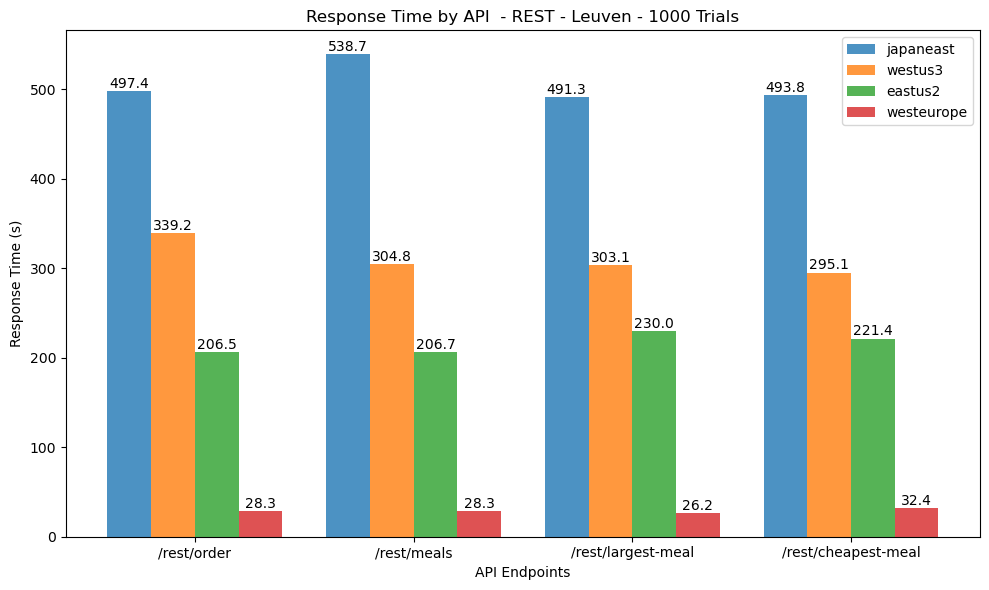

In [120]:
plot_data(rest_response_times_dict, num_requests, extra_title='REST - Leuven');

### Run the SOAP requests

In [121]:
# read the soap requests from the directory
soap_request_list = []
soap_dir = 'soap_requests'
for filename in os.listdir(soap_dir):
    with open(os.path.join(soap_dir, filename), 'r') as f:
        data = f.read()
        soap_request_list.append(['/ws', data.strip()])

soap_port = 8082

# call concurrent_test() with soap_request_list
soap_response_times_dict = {}
for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue

    # test REST or SOAP
    response_times = concurrent_test(dns, soap_port, soap_request_list, num_requests, req='SOAP')
    
    for url, times in response_times.items():
        if url not in soap_response_times_dict:
            soap_response_times_dict[url] = {}
        soap_response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 475.834
URL: name, Method: ('name', 'Portobello'), Total Response Time: 458.426
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 472.703
URL: meals, Method: ('meals', 'Steak'), Total Response Time: 462.137


Server: westus3
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 296.34
URL: name, Method: ('name', 'Portobello'), Total Response Time: 295.477
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 298.947
URL: meals, Method: ('meals', 'Steak'), Total Response Time: 299.903


Server: eastus2
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 247.965
URL: name, Method: ('name', 'Portobello'), Total Response Time: 252.128
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 259.695

## SOAP Requests - Leuven

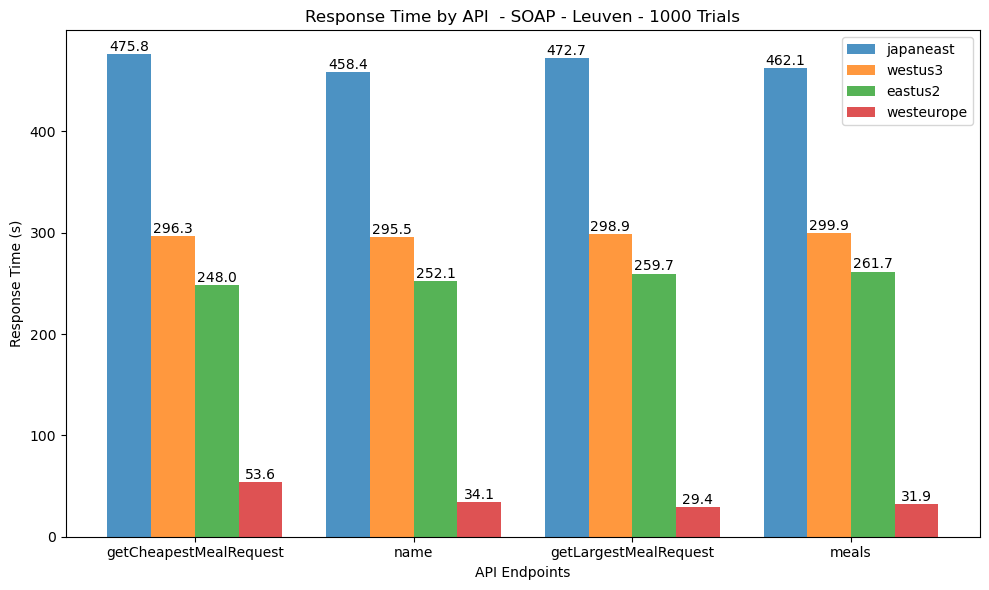

In [126]:
plot_data(soap_response_times_dict, num_requests, extra_title='SOAP - Leuven');

# Data from the Azure VMs 
## West Europe
### REST Requests - West Europe

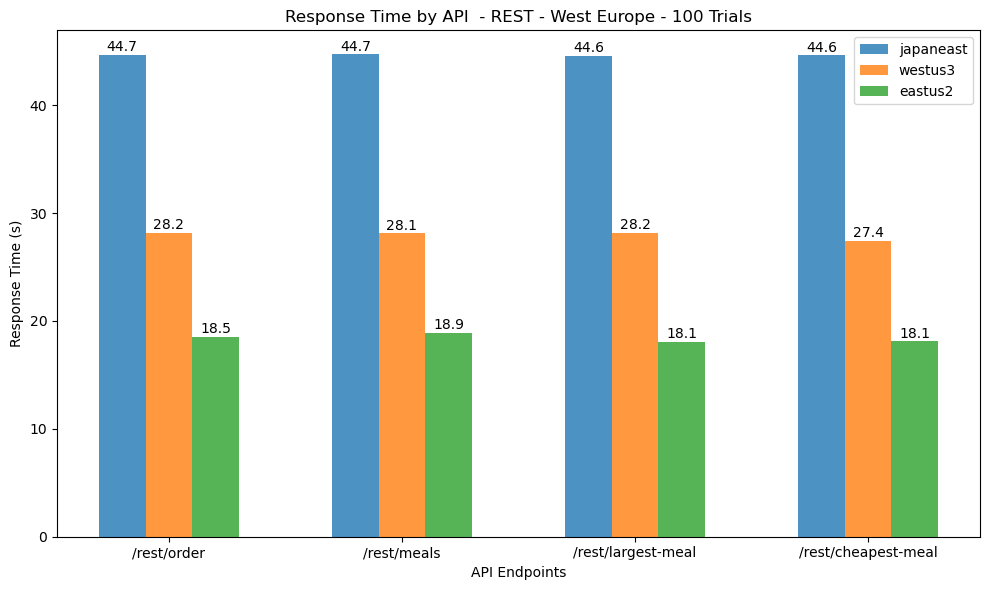

In [123]:
west_europe_rest = load_dict_from_pickle_file('pickles/west_europe_rest.pickle')
plot_data(west_europe_rest, 100, extra_title='REST - West Europe');

### SOAP Requests - West Europe

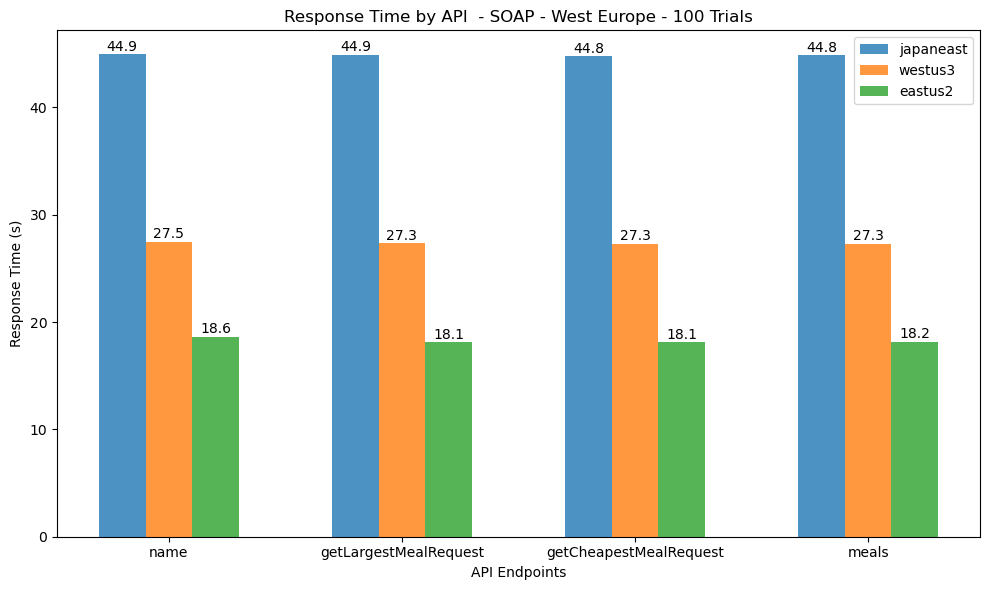

In [124]:
west_europe_soap = load_dict_from_pickle_file('pickles/west_europe_soap.pickle')
plot_data(west_europe_soap, 100, extra_title='SOAP - West Europe');

## East US
### REST Requests - East US

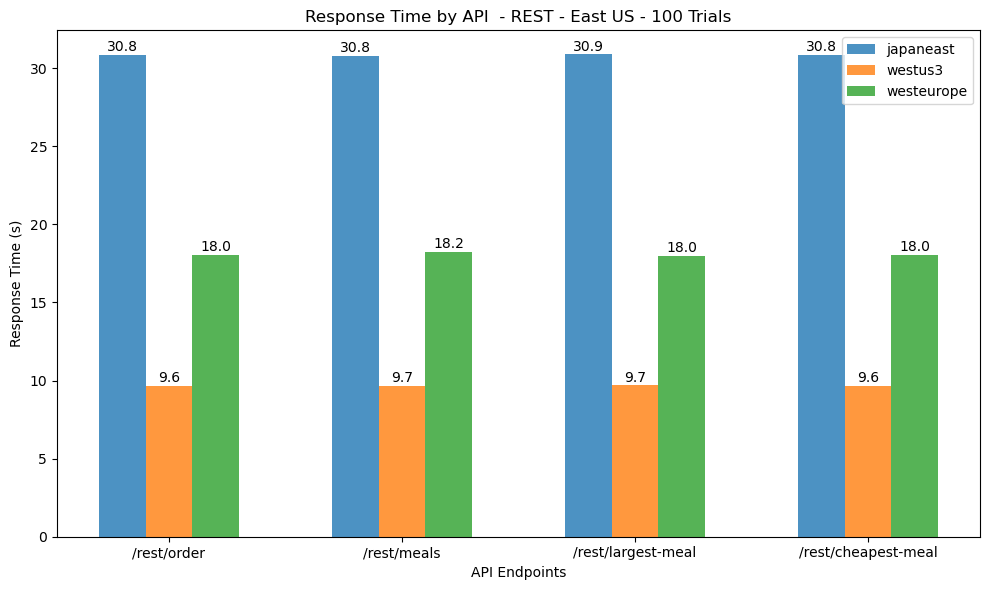

In [125]:
east_us_rest = load_dict_from_pickle_file('pickles/east_us_rest.pickle')
plot_data(east_us_rest, 100, extra_title='REST - East US');

# Azure Metrics
## Japan East

### CPU Usage
![japanCPU](report/server_test_files/japanCPU.png)

### Credit Usage
![japanCredit](report/server_test_files/japanCredit.png)


# Observations

1. **Geographical Proximity**: The response times are generally shorter when the server is geographically closer to the client. In this case, since the client is running the code from West Europe, the response times for the West Europe server are significantly lower than the response times for servers located in Japan, East US, and West US.

2. **API Type**: REST API response times are generally lower than SOAP API response times due to JSON being more compact and faster to parse than XML used by SOAP APIs. REST APIs also have a simpler message structure.

3. **CPU and Credit Usage**: Azure's CPU and credit usage increases during request processing.